# Sound source localization with a microphones array : beamforming approaches

You have characterized and analyzed the sound propagation in the previous practical. We will now
exploit theses properties to infer one sound source position w.r.t.\ a linear microphone array made
of $N=8$ omnidirectional MEMS microphones. The system you will be using is the same as before;
thus, most of the code you already wrote to acquire signals, plot them, etc.\ will remain the same.

In all the following, the acquisition system will work with a sampling frequency $F_s = 20$kHz, and with a buffer of size $\texttt{BLK} = 2048$.

In [1]:
# All required import
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from client import array
import time
%matplotlib notebook

In [56]:
antenne=array('server') # When performing real-time acquisition
#antenne=array('play')   # When playing recorded files

In [2]:
antenne=array('play') 

In [9]:
# Load acquisition and array parameters from the antenne variable, after launching acquisition or play
Fs = antenne.fs
BLK = antenne.blocksize
N = antenne.mems_nb
d = antenne.interspace

### 1) To begin, start the acquisition of the audio system, and capture one audio buffer. Plot the resulting signals as a function of time.

<IPython.core.display.Javascript object>


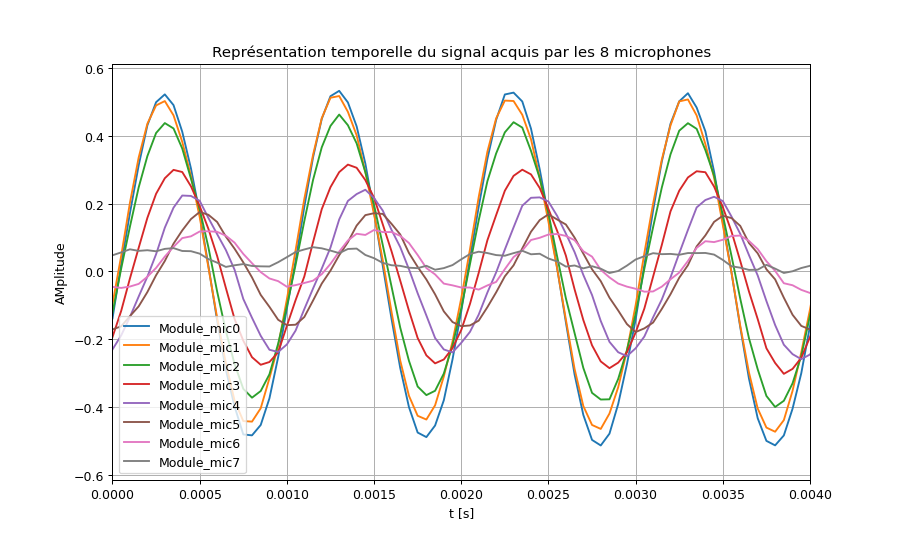

In [11]:
# Read an audio buffer
m = antenne.read()

# Read an audio buffer
t = [i/Fs for i in range(m.shape[1])]

plt.figure(figsize=(10,6))
for i in range(len(m)):
    plt.plot(t, m[i],label=f'Module_mic{i}')
plt.xlabel("t [s]")
plt.ylabel("AMplitude")
plt.title("Représentation temporelle du signal acquis par les 8 microphones")
plt.xlim(0,0.004)
plt.legend()
plt.grid()
plt.show()

## 2.1/ Coding the beamformer filters and analyzing their properties

**These first questions have to be prepared before the practical session**

### 2) Write the position $z_n$ as a function of $n$ and interspace $d$. As a convention, the first microphone number is selected as $0$.

One can write :
$$z_n = d\times(n - \frac{N+1}{2})$$

### 3) Propose a function $\texttt{beam_filter}$ returning the filter frequency response for one microphone number $\texttt{mic_nb}$. 

In [2]:
def beam_filter(array, freq_vector, theta0=0, mic_nb: int = 0):
    """Compute the filter frequency response of a DSB beamformer for one microphone

    Args:
        array (array_server obj): array structure controlling the acquisition system.
        freq_vector (np.array): frequency vector. 
        theta0 (int, optional): focusing angular direction (in degrees). Defaults to 0.
        mic_id (int, optional): microphone id. Defaults to 0.

    Returns:
        np.array: the filter frequency response. Shape is (len(freq_vector),).
    """
    N = array.mems_nb
    d = array.interspace
    # Microphone position x
   
    z = d*(mic_nb-((N+1)/2))
    # Filter's frequency response
    W = np.exp(-1j*2*np.pi* (freq_vector/340) *z*np.cos(theta0 * np.pi/180))
    return W

### 4) Plot the two frequency responses obtained for two filters associated to two different microphone outputs when $\theta_0=0^\circ$ and for frequencies between $0$ and $5$kHz. Explain the effect of these filters on the signals.

<IPython.core.display.Javascript object>


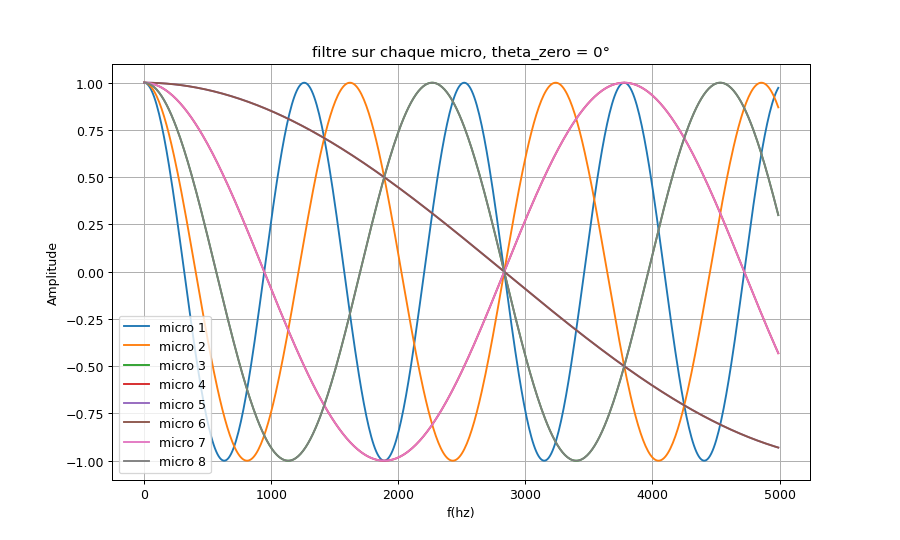

In [15]:
F = np.arange(0, 5000, Fs/BLK)
plt.figure(figsize=(10,6))
for i in range(N):
    W90 = beam_filter(antenne, F, 0, i)
    plt.plot(F, W90, label = f"micro {i+1}")
plt.title("filtre sur chaque micro, theta_zero = 0°")
plt.xlabel("f(hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


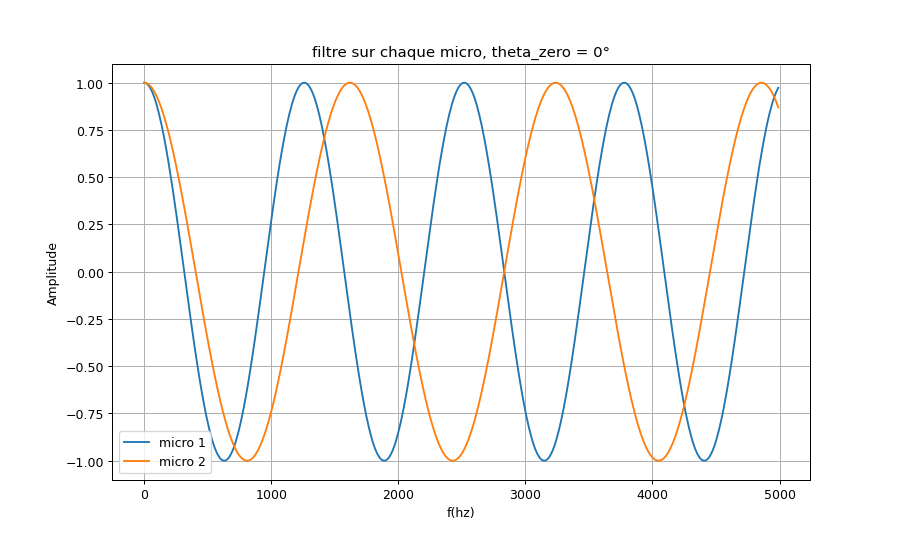

In [17]:
F = np.arange(0, 5000, Fs/BLK)
plt.figure(figsize=(10,6))
for i in range(2):
    W90 = beam_filter(antenne, F, 0, i)
    plt.plot(F, W90, label = f"micro {i+1}")
plt.title("filtre sur chaque micro, theta_zero = 0°")
plt.xlabel("f(hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

- On remarque que pour $\f1_1$ = $\f1 _2$ = 0 Hz, le premier pics des deux signaux est le même, or que pour le deuxième pic il sera pour le microphone N°1 à une fréquence $\f2 _1$ égale à environ 1245 Hz et pour le microphone N°2 à une fréquence $\f2 _2$ environ 1615 Hz.  Même remarque troisième pic, $\f3 _1$ = 2515 Hz et $\f3 _2$ = 3245 Hz.
- Quand on applique les filtres à nos 8 microphones on ajoute un retard en fonction de $\theta _0$, en fonction de ce dérnier et lors de la sommation on aura des ondes destructive ce qui nous permetrra d'avoir une bande passnte de theta pour la quelle notre array laissera passer le son. 

### 5) Compare again the filters obtained when $\theta_0 = 90^\circ$. Explain the differences.

<IPython.core.display.Javascript object>


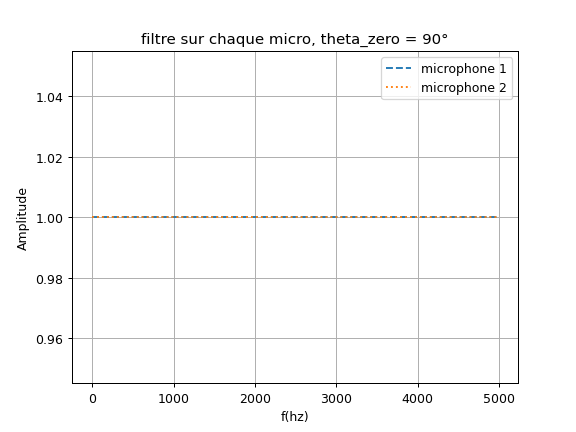

In [37]:
F = np.arange(0, 5000, Fs/BLK)
plt.figure()
W90 = beam_filter(antenne, F, 90, 0)
plt.plot(F, W90, label = "microphone 1",linestyle='--' )
W90 = beam_filter(antenne, F, 90, 0)
plt.plot(F, W90, label = "microphone 2",linestyle=':')
plt.title("filtre sur chaque micro, theta_zero = 90°")
plt.xlabel("f(hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


Pour $\theta _0$ = 90° on aura cos(90°) = 0, dans ce cas l'exponentielle vaut 1. </br>
Ainsi chaque filtre sera égal à 1 et n'auront aucun effet sur les micros. </br>
Dans le domamine fréquentielle l'effet du beamforming vu en cour sera constater lors de la sommation de chaque microphones,
on va choisir uniquement les angles à 90° avec plus au moins quelques degrés. 


## 2.2/ Using the filters : coding of the beamforming
Basically, the beamforming algorithm is the following :

- (a) acquire an audio frame
- (b) compute the corresponding FFT
- (c) analyze the FFT to define which frequency(ies) you would like to localize
- (d) restrict the FFT to the frequencies of interest
- (e) for one given ✓ 0 , for the frequencies selected before, and for each microphone :
  — compute the corresponding filters frequency responses with the beam_filter func-
tion
  — apply these filters to the microphone outputs
- (f) compute the beamformer output associated to the angular polarization ✓ 0
- (g) repeat all these last steps for each ✓ 0 you want to test
- (h) finally, decide of the angular position of the source by detecting for which ✓ 0 the beam-
former output is maximum.

### 6) Step (a) and (b) : After acquiring an audio buffer, compute its FFT in an array $\texttt{M_fft}$. Plot the result of this analysis as a function of the frequency when emitting a pure sine tone with a frequency $F_0 = 1$kHz.

<IPython.core.display.Javascript object>


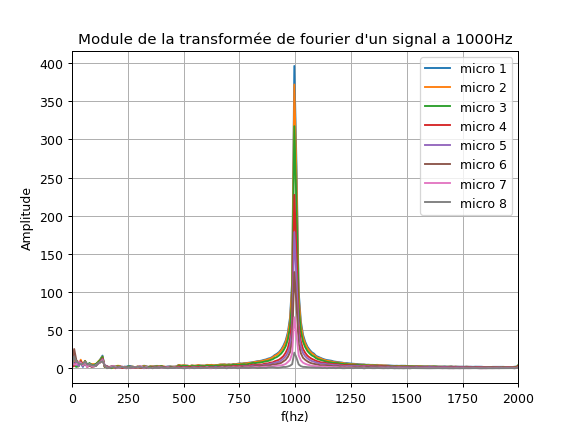

In [39]:
F0 =  1000
Freq  = np.arange(0, Fs, Fs/BLK)
Mfft = np.fft.fft(m)
plt.figure()
for i in range(len(Mfft)):
    plt.plot(Freq, np.abs(Mfft[i]),  label = f"micro {i+1}")
plt.title("Module de la transformée de fourier d'un signal a 1000Hz")
plt.xlabel("f(hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.xlim((0,2000))
plt.show()


On commence notre analyse sur l'axe des fréquences, on remarque bien des pics au alentour des 1000 Hz qui est tout à fait logique car c'est notre fréquence d'intérêt, néanmoins un leger bruit est présent entre 0 et 200 Hz. 
Ce bruit est justifié par plusieurs facteur : le bruit du néon (entre 50 et 70 Hz) , le bruit des peronnes qui parlent durant l'enregistrement (entre 75 à 140 Hz pour les hommes et 170 à 250 Hz pour les femmes).

<IPython.core.display.Javascript object>


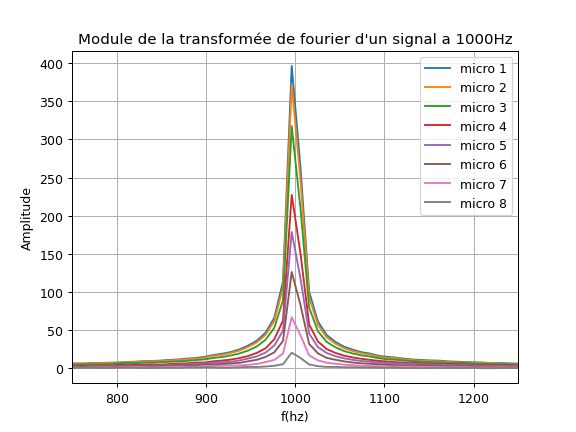

In [41]:
plt.figure()
for i in range(len(Mfft)):
    plt.plot(Freq, np.abs(Mfft[i]),  label = f"micro {i+1}")
plt.title("Module de la transformée de fourier d'un signal a 1000Hz")
plt.xlabel("f(hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.xlim((750,1250))
plt.show()


on poursuit notre analyse sur l'axe d'amplitude, on remaque que l'amplitude du microphone N°1 est 16 fois plus importante que celle du microphones N°8 ce qui tout à fait logique car L'enregistement a été effectué avec un angle theta.

étant donné que la source est proche (pas vraiment a l'infini), le téléphone étant très orienté vers le micro 1 et 2, leur amplitude est plus grande


Contraitement au domaine temporal, dans le domaine fréquentiel on ne remarque pas de retard. 

### 7) Step (c) and (d) : Among all the frequencies you obtained from the FFT, select the one corresponding to the source frequency. Give its exact value and index $k_0$ in the frequency array, and collect the corresponding FFT values of each microphone outputs in one vector $\texttt{M}$ of length $N$.

In [42]:

k0 = (np.argmin(np.abs(Freq - F0)))
print("k0:",k0)
print("Frequence a k0:", Freq[k0])

M = []
Mft = np.fft.fft(m)
M = Mft[:,k0] 


print("Valeurs de M : ")
print(M)
k0_1 = np.argmax(np.array(Mft[3,:]))

k0: 102
Frequence a k0: 996.09375
Valeurs de M : 
[327.94481532-222.1769637j  315.75014689-196.38093693j
 246.87156652-199.21726865j 119.51134569-193.36105355j
   4.43330988-178.50163788j -51.20351159-115.30033294j
 -32.88598499 -58.2631407j   19.52642306  -6.46148704j]


On a déteerminé l'indice k0 pour le quel on observe le pics à notre fréquence d'intret qui est de 1000 Hz,
ensuite on calcule la FFT et on extrait la réponse de chaque microphones (c'est pour ca que la matrice est composée de 8 valeurs complex).

### 8) Step (e) : In a loop among all microphones, compute each filters for the position $\theta_0$ and for the frequency value you obtained in the previous step. Apply then these filters to the array $\texttt{M}$ defined before.

In [45]:
W= []
for i in range(N):
    W.append(beam_filter(antenne, Freq[k0], theta0 = 0, mic_nb=i))

W = np.array(W)
YW = W*M
print(YW)

[-131.25802464-373.74019862j -366.62575766 -62.04177203j
 -155.24895343+276.64210263j  182.3943041 +135.66051971j
   97.41443896-149.64262776j -104.07774057 -71.30070332j
  -55.22677278 +37.76354249j  -20.52966378  -1.25096661j]


on applique un filtrage pour chaque sortie de microphones.

### 9) \textbf{Step (f):} Combine then the filters outputs to form the beamformer output $Y_{\theta_0}[k_0]$. *$Y_{\theta_0}[k_0]$ is obviously a complex value which corresponds to the frequency contribution of the source to the $k_0^{\text{th}}$ frequency component of the beamformer output when focalized in the direction $\theta_0$.* Compute then the corresponding power $P(\theta_0)$ at $k_0$ of the beamformer output.

In [46]:
Y_tet0 = np.sum(YW)

P = np.sum(np.abs(YW))**2

print("réponse en sortie Y pour k0: ",Y_tet0)
print("Puissnace pour k0: ",P)

réponse en sortie Y pour k0;  (-553.1581697911666-207.91010351251418j)
Puissnace pour k0:  2905949.451048238


On a maintenant la réponse en sortie Y pour k0, cette réponse est la somme des sorties des 8 microphones d'ou le np.sum , la puissance est calculée suivant sa forumle classique.

### 10) For a direction $\theta_0$ of your choice, compute $P(\theta_0)$ for (i) a source emitting from a direction close to $\theta_0$, or (ii) far from it. Compare the two values.

In [51]:
# For theta0 = 90°
W = []
for i in range(N):
    W.append(beam_filter(antenne, Freq[k0], theta0 = 90, mic_nb=i))

YW = M * W


Y_tet90 = np.sum(YW)

P90 = np.abs(Y_tet90)**2

print(f"Y_tet90[k0] vaut :", Y_tet90)
print("La puissance P vaut :", P90)


Y_tet90[k0] vaut : (-70.22806444833621+1491.522273050464j)
La puissance P vaut : 2229570.672041782


In [52]:
# For theta0 = 0°
W = []
for i in range(N):
    W.append(beam_filter(antenne, Freq[k0], theta0 = 0, mic_nb=i))

YW = M * W


Y_tet90 = np.sum(YW)

P90 = np.abs(Y_tet90)**2

print(f"Y_tet90[k0] vaut :", Y_tet90)
print("La puissance P vaut :", P90)


Y_tet90[k0] vaut : (567.7535022146315-155.8648317485714j)
La puissance P vaut : 346637.88505299


on remarque que la puissance pour $\theta_0 = 90^\circ$ est plus grande que la puissance pour $\theta_0 = 0^\circ$, en effet la source a été placé à environ $\theta_0 = 100^\circ$.

### 11) Step (g) : Repeat now the previous code in a loop for $\theta_0$ values ranging from 0 to 180° .You should then obtain an array $\texttt{P}$ where each value corresponds to the power of the beamformer output at $F_0$ for each angular polarization. Plot the array $\texttt{P}$ as a function of the angle $\theta_0$.

<IPython.core.display.Javascript object>


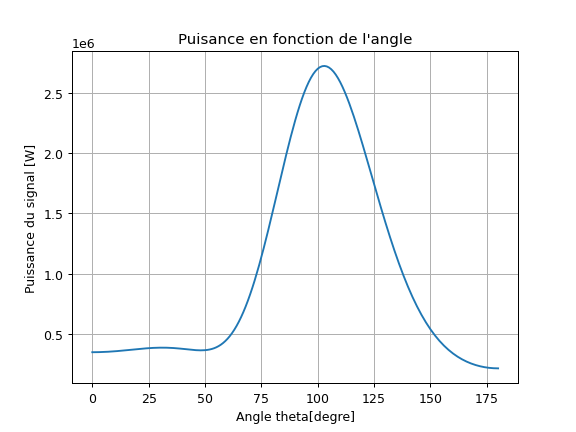

In [48]:
thetas = np.arange(0, 181, 1)
Power = []
for theta in thetas:
    W = []
    for i in range(N):
        W.append(beam_filter(antenne, Freq[k0], theta0 = theta, mic_nb= i))
    YW = M*W
    P = np.abs(np.sum(YW))**2
    Power.append(P)


plt.figure()
plt.plot(list(thetas), Power)
plt.xlabel("Angle theta[degre]")
plt.ylabel("Puissance du signal [W]")
plt.title("Puisance en fonction de l'angle")
plt.grid()
plt.show()

Le beamforming nous retourne donc bien un maximum aux alentours de 100 degré

### 12) Step (h) : Find the $\theta_0$ value corresponding to position of the maximum in $\texttt{P}$ and compare it with the actual (but approximate) position of the sound source.

In [62]:
theta_o=np.argmax(Power)
print("max de la puissance pour theta :",theta_o )
print("max puissnace",Power[theta_o])

max de la puissance pour theta : 103
max puissnace 2721753.543667142


Pendat l'acquisisition nous avions un réalité terrain de $\theta_0 = 100^\circ$ avec plus au moins 5° ( nous avons pas calculé avec exactitude l'angle).
L'angle pour le quel la puissance est maximale est de 103° qui est presque equivaut à la réalité terrain.

## 2.3/ Analyzing the beamformer performances

From now on, you can use your own code written in Section 2.2, or use the provided beamformer function which exactly reproduces the beamformer algorithm. You might then add $\texttt{from beamformer_etu import beamformer}$ in your Notebook before being able to use the beamformer function.

In [3]:
def beamforming(m, thetas, F0 , Fs):
    N, BLK = np.shape(m)
    Mfft = np.fft.fft(m)
    Freq = np.arange(0, Fs, Fs/BLK)
    k0 = (np.argmin(np.abs(Freq - F0)))

    #On selectionne pour chaque micro la fréquence d'interet k0
    M = Mfft[:, k0]
    Power = []    
    for theta in thetas:
        W = []
        for i in range(N):
            W.append(beam_filter(antenne, Freq[k0], theta0 = theta, mic_nb= i))
        YW = M*W
        P = np.abs(np.sum(YW))**2
        Power.append(P)
    return Power

<IPython.core.display.Javascript object>


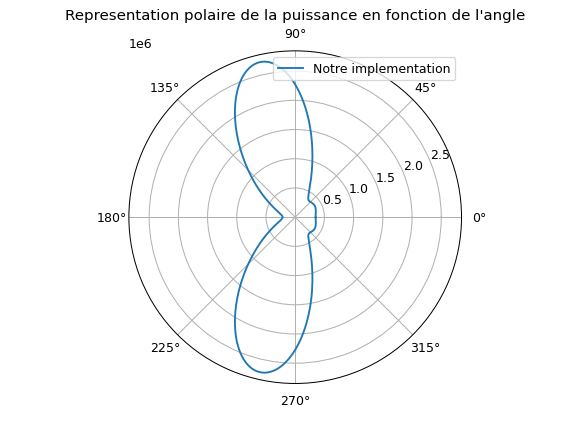

In [68]:
thetas = np.arange(0,180, 1)
plt.figure()
deg = np.arange(0, 360, 1)
plt.polar(deg*np.pi/180, beamforming(m, deg, 1000, Fs), label = "Notre implementation")
#plt.polar(deg*np.pi/180, bf.beamformer(m, deg, 1000, Fs), label = "Implémentaiton du prof")
plt.title("Representation polaire de la puissance en fonction de l'angle")
plt.legend()
plt.show()

### 13) Plot the energy maps you obtain when using source frequencies $F_0 = 400$Hz, $F_0 = 1$kHz, $F_0 = 2$kHz and $F_0 = 4$kHz emitting from a fixed arbitrary position. Comment and explain carefully the differences between these curves

In [4]:
P_400=[]
P_1000=[]
P_2000=[]
P_4000=[]

thetas = np.arange(0,180, 1)
Fs=20000

In [5]:
# f0= 400 Hz
antenne=array('play') 

In [6]:
F0=400
m_400= antenne.read()
P_400=beamforming(m_400, thetas, F0 , Fs)


<IPython.core.display.Javascript object>


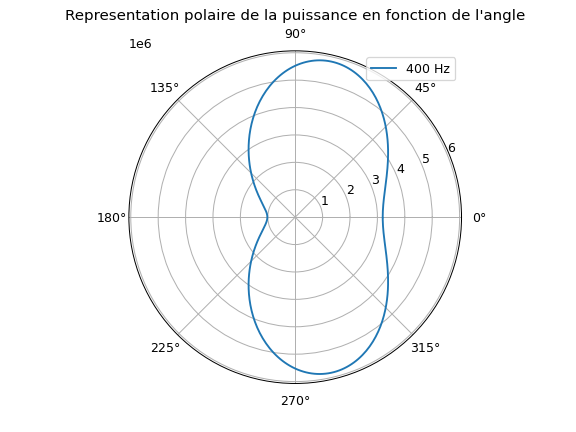

In [8]:
plt.figure()
deg = np.arange(0, 360, 1)
plt.polar(deg*np.pi/180, beamforming(m_400, deg, 400, Fs), label = "400 Hz")
plt.title("Representation polaire de la puissance en fonction de l'angle")
plt.legend()
plt.show()

In [9]:
# f0= 1000 Hz
antenne=array('play') 

In [10]:
F0=1000
m_1000= antenne.read()
P_1000=beamforming(m_1000, thetas, F0 , Fs)

<IPython.core.display.Javascript object>


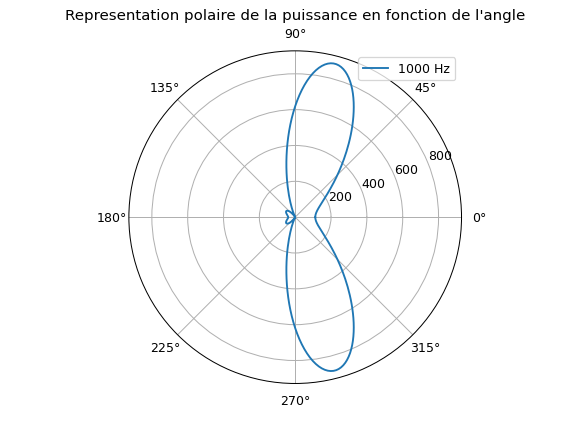

In [13]:
plt.figure()
deg = np.arange(0, 360, 1)
plt.polar(deg*np.pi/180, beamforming(m_1000, deg, 1000, Fs), label = "1000 Hz")
plt.title("Representation polaire de la puissance en fonction de l'angle")
plt.legend()
plt.show()

In [5]:
# f0= 2000 Hz
antenne=array('play') 

In [10]:
F0=2000
m_2000= antenne.read()
P_2000=beamforming(m_2000, thetas, F0 , Fs)

<IPython.core.display.Javascript object>


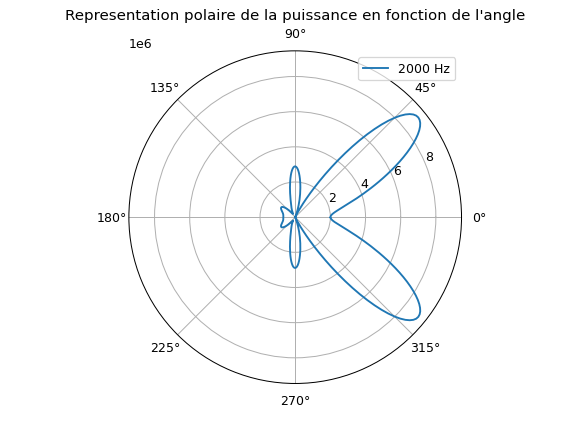

In [11]:
plt.figure()
deg = np.arange(0, 360, 1)
plt.polar(deg*np.pi/180, beamforming(m_2000, deg, 2000, Fs), label = "2000 Hz")
plt.title("Representation polaire de la puissance en fonction de l'angle")
plt.legend()
plt.show()

In [19]:
# f0= 4000 Hz
antenne=array('play') 

In [20]:
F0=4000
m_4000= antenne.read()
P_4000=beamforming(m_4000, thetas, F0 , Fs)

<IPython.core.display.Javascript object>


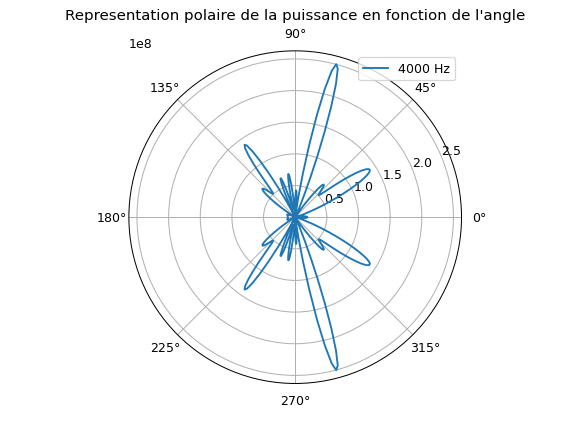

In [21]:
plt.figure()
deg = np.arange(0, 360, 1)
plt.polar(deg*np.pi/180, beamforming(m_4000, deg, 4000, Fs), label = "4000 Hz")
plt.title("Representation polaire de la puissance en fonction de l'angle")
plt.legend()
plt.show()

- Le diagramme de directivité d'une antenne varie avec la fréquence d'intérêt. Ainsi, une antenne est plus directive lorsque la fréquence d'intérêt augmente. Cependant, si la valeur maximale de la fréquence d'intérêt est dépassée (non respectant du théorème de Shannon) : $d < dmax = λmin * c/2fmax$, le diagramme de directivité laisse passer des ondes acoustiques provenant de directions différentes non souhaitées, ceci est décrit par un repliement spectral dans le domaine fréquentiel, on note le diagramme est symétrique (0° à 180° et de 180° à 360°), dans notre analyse on va s'intéresser à la premiere partie seulement.

- Si la source émet un signale de fréquence importante, on constate que le lobe principale semble être plus fin, on retrouve des lobe secondaires en plus grand nombre mais d'amplitudes décroissante  (étonnant).

- Fréquences faibles,  on récupère des diagrammes d'antienne et tellement plus large jusqu'as ne pas avoir des lobe secondaires. Donc, quand la fréquence diminue, le diagramme d'antenne est de moins en moins sélectif, hors ca ca peut paraitre étonnant, mais finalement les fréquences sont associer à des longueur d'ondes et en plus on a affaire à un microphone linéaire et équidistant, on est face à un système de formation de voie qui est entrain d'effectuer un échantillonnage spécial de l'information acqoustique, cette échantillonnage et effectuer par un réseau de microphone placer régulièrement  dans l'espace et cette échantillonnage est plus au moins adapter à la fréquence de l'onde sonore que avec laquelle nous travaillons, visiblement pour des fréquences faibles associer a de grande longueurs d'onde on a un échantillonnage spécial qui s'opère sur 42 cm  et pour qui est associer à une longueur d'onde de 400hz  visiblement cette longueur n'ai pas très importante par rapport à la longueur d'onde à échantillonner et donc on récupère une information/sélectivité spatial extrêmement faible. 

- Le dernier phénomène, il est extrêmement important, car à présent on ce dit que à chaque fois l'on augmente la fréquence le diagramme d'antenne est sélectif, mais le problème lorsque nos sources émet des fréquences trop hautes, on récupère toujours un  primer lobe dans le diagramme d'antenne qui correspond au fréquence d'intérêt (d'habitude un lobe extrêmement fin), des lobe secondaires d'amplitudes qui vont on diminuant, mais aussi d'autres lobes secondaires avec une grande amplitudes! enfaite en est dans un cas analogue  de ce que on appelle le repliement spectrale qui directement lier au fait que nous avons pas respecter le théorème de Shannon spatial, qui a pour conséquences visiblement que l'on récupère des onde sonore dans d'autres directions non souhaitées., et concrètement  cela veut dire on est incapable de faire la différence entre les source qui émissent des ondes sonores dans les différentes positions et donc incapable de retrouver la position spatial de la source sonore souhaité.

- Pour la fréquence 2000 Hz, la directivité est entre 0° est 45° au lieu être situé entre 45° et 90° comme pour les autres fréquences. On a surement toucher au téléphone(recevoir un appel ou bien la battrie était faible) et sur ce fait le position de la source est différente des autres fréqunces(400 Hz, 1000 Hz, 4000 HZ)

### 14) For a frequency $F_0 = 1$kHz and a source moving aroud the array, plot the estimated position as a function of time. Comment the effectiveness of the approach and its limits.

In [4]:
antenne=array('play') 

In [5]:
# Load acquisition and array parameters from the antenne variable, after launching acquisition or play
Fs = antenne.fs
BLK =antenne.blocksize
N = antenne.mems_nb
d = antenne.interspace


In [10]:
# Read an audio buffer
import time
m_14 =np.array([])

#Fs=20000, BLK=2048 donc nous avons un beamforming toutes les 0.1s, or notre audio contient environs 11s , on  va utiliser que les 
#6 premiere second (le reste n'est pas utilie ) , donc 6s/0.1s on aura 60 itérations
for i in range(70):
    if i==0:
        m_14=antenne.read()
    else : 
        m_14=np.concatenate((m_14,antenne.read()),axis=1)
    time.sleep(0.1024)
    print(m_14.shape)
# Read an audio buffer
t = [i/Fs for i in range(m_14.shape[1])]

(8, 2048)
(8, 4096)
(8, 6144)
(8, 8192)
(8, 10240)
(8, 12288)
(8, 14336)
(8, 16384)
(8, 18432)
(8, 20480)
(8, 22528)
(8, 24576)
(8, 26624)
(8, 28672)
(8, 30720)
(8, 32768)
(8, 34816)
(8, 36864)
(8, 38912)
(8, 40960)
(8, 43008)
(8, 45056)
(8, 47104)
(8, 49152)
(8, 51200)
(8, 53248)
(8, 55296)
(8, 57344)
(8, 59392)
(8, 61440)
(8, 63488)
(8, 65536)
(8, 67584)
(8, 69632)
(8, 71680)
(8, 73728)
(8, 75776)
(8, 77824)
(8, 79872)
(8, 81920)
(8, 83968)
(8, 86016)
(8, 88064)
(8, 90112)
(8, 92160)
(8, 94208)
(8, 96256)
(8, 98304)
(8, 100352)
(8, 102400)
(8, 104448)
(8, 106496)
(8, 108544)
(8, 110592)
(8, 112640)
(8, 114688)
(8, 116736)
(8, 118784)
(8, 120832)
(8, 122880)
(8, 124928)
(8, 126976)
(8, 129024)
(8, 131072)
(8, 133120)
(8, 135168)
(8, 137216)
(8, 139264)
(8, 141312)
(8, 143360)


<IPython.core.display.Javascript object>


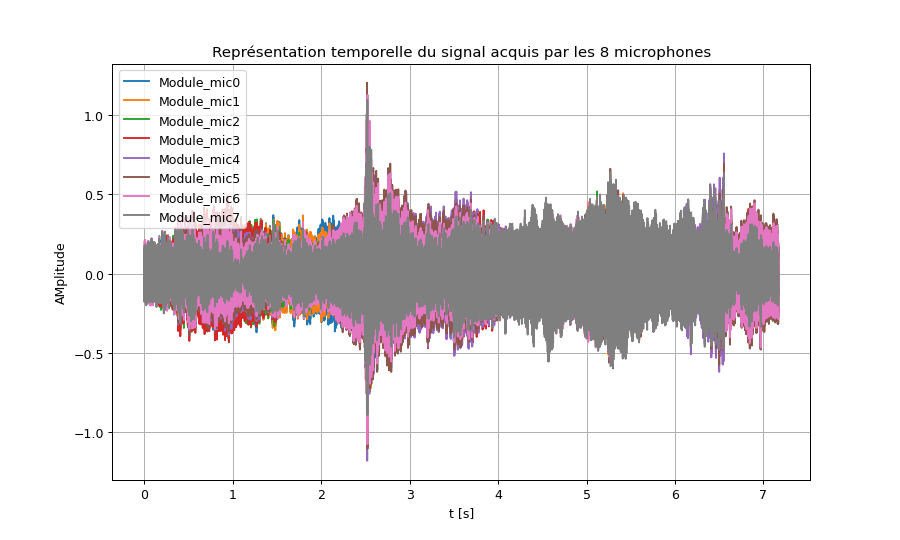

In [11]:

plt.figure(figsize=(10,6))
for i in range(len(m_14)):
    plt.plot(t, m_14[i],label=f'Module_mic{i}')
plt.xlabel("t [s]")
plt.ylabel("AMplitude")
plt.title("Représentation temporelle du signal acquis par les 8 microphones")
plt.legend()
plt.grid()
plt.show()
# TE BE COMPLETED

In [12]:
F0 = 1000
k = 0
P_max = []
t = [] 

thetas = np.arange(0,181, 1)
for i in range(0, m_14.shape[1]-BLK, BLK):
    m = m_14[:,i:i+BLK]
    k+= BLK
    P = beamforming(m, thetas, F0, Fs)
    P_max.append(np.argmax(P))
    t.append(i/Fs)

<IPython.core.display.Javascript object>


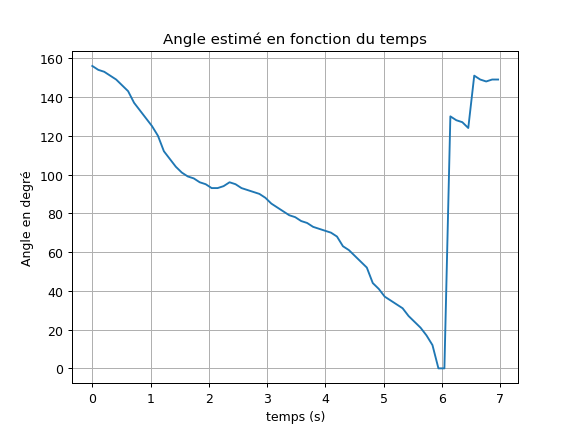

In [14]:
plt.figure()
plt.plot(t, P_max)
plt.xlabel("temps (s)")
plt.ylabel("Angle en degré")
plt.title("Angle estimé en fonction du temps")
plt.grid()

- On devrait trouver une allure de l'angle $\theta$ qui augmente ou diminue en fonction du temps et en fonction de notre trajectoire (de 0° à 180 ° ou de 180° à 0°). Si nous partons de 0 à 180°la fonction augmente, sinon, l'inverse.

- Dans notre cas on part de 180° à 0°, néanmoins on commence par un maximum de 160°, cela est dû a une mauvaise synchronisation entre la personne qui fait la déplacements de le source sonore et le personne devant l'ordinateur portable qui lance l'acquisition.

- On a vu que $f= 1000 Hz$ n'était pas très sélectif , Plusieurs directions ont une énergie élevée ce qui peut fausser le résultat lorsqu'on recherche le puissance maximale.

- Le fait de faire un demi-circle avec une distance constante n'a pas était respecté lors de l'acquisiton ce qui justifie la forme de la courbe, à paritir de $t= 6s$ on refait le Sens inverse mais avec une vitesse plus rapide(d'ou le 0 à 130° en une fraction de seconde), une fois de plus cette anomalie fait partie des erreurs terrain lors de l'expérimentation.

### Conclusion 

En conclusion, ce TP nous a permis de mettre en pratique les différentes notions vues dans le cours de Beamforming pour la localisation spatial d'une source sonore.    

La localisation acoustique est une technique permettant de mesurer l'intensité et la direction d'une source sonore. Une technique populaire pour son calcul est l'algorithme de Beamforming "Sum-and-Delay", qui génère un angle approximatif de son emplacement tout en réduisant le bruit dans le signal.       

Le Beamforming repose sur le fait que différents haut-parleurs répondent au même signal d'entrée de différentes manières, par exemple en retardant légèrement le signal, en le jouant à des volumes différents ou en utilisant des effets d'annulation. Les différents réglages des haut-parleurs permettent au système de contrôler la taille, la forme et la direction de l'onde sonore.  Ces opérations sont effectuées à l'aide du diagramme de directivité $D(r,k)$ qui représente le filtrage spatial et fréquentiel effectué par le réseau de microphones.

Les résultats obtenus et les phénomènes observés sont en accord avec nos attentes. 

Nous tenons à remercions toute personne ayant contribuées pour la réalisation de ce TP.